## **1. Importando as bibliotecas**

In [1]:
pip install azure-storage-blob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00


In [2]:
pip install azure-identity azure-keyvault-secrets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 11.5 MB/s eta 0:00:00


In [4]:
!pip install azure-storage-blob pandas

In [45]:
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from io import BytesIO
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns

In [6]:
######################Instalação do azure CLI e login#######################################
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
!az --version
!az login

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,550 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,795 kB]
Hit:14 https://ppa.launchpad

##2. **Importando Key Vault**

In [7]:
key_vault_name = "carolkeyvault1234" #Minhas configurações de chaves no Azure Key Vault
secret_name = "secretcarol1234"

In [8]:
key_vault_url = f"https://{key_vault_name}.vault.azure.net"

In [9]:
credential = DefaultAzureCredential()

In [10]:
client = SecretClient(vault_url=key_vault_url, credential=credential)

In [11]:
retrieved_secret = client.get_secret(secret_name)
connect_str = retrieved_secret.value

##**3. Conectando no Azure Blob Storage para poder acessar as bases**

In [12]:
######################Obtendo o segredo para conectar no azure blob storage######################################
try:
    retrieved_secret = client.get_secret(secret_name)
    connect_str = retrieved_secret.value
    if not connect_str:
        raise ValueError("O segredo está vazio.")
    print("Valor do segredo obtido com sucesso.")
except Exception as e:
    print(f"Erro ao obter o segredo: {e}")
    raise

Valor do segredo obtido com sucesso.


In [13]:
######################Conectando ao azure blob storage##################################
try:
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    print("BlobServiceClient conectado com sucesso.")
except ValueError as e:
    print(f"Erro ao conectar ao BlobServiceClient: {e}")
    raise

BlobServiceClient conectado com sucesso.


##**4. Carregando os CSVs em dataframes**

Carregando os csvs através de conexão com o meu container no Azure Blob Storage, onde os arquivos estão alocados

In [14]:
storage_account_name = "carolstorageaccount"
container_name = "container1234"

In [15]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client(container_name)

In [16]:
blob_list = container_client.list_blobs()
csv_files = [blob.name for blob in blob_list if blob.name.endswith('.csv')]

In [17]:
def read_csv_from_blob(blob_name, delimiter):
    try:
        blob_name_with_path = f"nestle/{blob_name}"
        blob_client = container_client.get_blob_client(blob_name_with_path)
        blob_data = blob_client.download_blob().readall()

        chunks = pd.read_csv(BytesIO(blob_data), delimiter=delimiter, engine='python', chunksize=10000)
        df = pd.concat(chunks)
        return df
    except Exception as e:
        print(f"Erro ao ler o blob {blob_name_with_path} com o delimitador '{delimiter}': {e}")
        return None

def clean_dataframe(df):
    # Ajustando colunas sem nome no csv
    df_cleaned = df.loc[:, ~df.columns.str.contains('^Unnamed')].dropna(how='all', axis=1)
    return df_cleaned

In [18]:
df_cargos = read_csv_from_blob("BaseCargos.csv", delimiter=';')
df_cep = read_csv_from_blob("BaseCEP.csv", delimiter='|')
df_clientes = read_csv_from_blob("BaseClientes.csv", delimiter=';')
df_funcionarios = read_csv_from_blob("BaseFuncionarios.csv", delimiter='|').replace('||','|')
df_nivel = read_csv_from_blob("BaseNível.csv", delimiter='%')
df_pq = read_csv_from_blob("BasePQ.csv", delimiter=';')

##**4. Transformação de dados**

In [19]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.1 MB/s eta 0:00:00


In [92]:
###Função para ajustar os hashs em dados sensíveis

import hashlib
def hash_value(value):
    value_str = str(value)
    return hashlib.md5(value_str.encode()).hexdigest()

### Base Cargos

In [20]:
##### tirando caracteres especiais da coluna de area
from unidecode import unidecode
import re
def remove_accents_and_special_chars(s):
    if s is None:
        return s

    # Remove "@" antes de palavras
    s = re.sub(r'@', '', s)

    accent_replacement = {
        'ç': 'c',
        'ã': 'a',
        'õ': 'o',
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u',
        'à': 'a',
        'è': 'e',
        'ì': 'i',
        'ò': 'o',
        'ù': 'u',
        'â': 'a',
        'ê': 'e',
        'î': 'i',
        'ô': 'o',
        'û': 'u',
        'Á': 'A',
        'É': 'E',
        'Í': 'I',
        'Ó': 'O',
        'Ú': 'U',
        'À': 'A',
        'È': 'E',
        'Ì': 'I',
        'Ò': 'O',
        'Ù': 'U',
        'Â': 'A',
        'Ê': 'E',
        'Î': 'I',
        'Ô': 'O',
        'Û': 'U'
    }

    # Remove acentos e substitui caracteres especiais
    for old, new in accent_replacement.items():
        s = s.replace(old, new)

    return s


df_cargos['Área'] = df_cargos['Área'].apply(remove_accents_and_special_chars)

In [23]:
df_cargos.head()

,Cargo,Nível,Área,COD Área,COD Nível,Quadro,Bonus,Contratacao
0,OPV,Diretor,Operacoes,JAJ,JE,Efetivo,S,Diretoria
1,LOI,Estagiário,Logisitca,EDE,JA,Efetivo,N,Gerente
2,ADI,Estagiário,Administrativo,BAC,JA,Efetivo,N,Gerente
3,ADII,Analista,Administrativo,BAC,DB,Terceiro,N,RH
4,OPII,Analista,Operacoes,JAJ,DB,Terceiro,N,RH


###Base CEP

In [24]:
df_cep.head()

,CEP,Estado,Região
0,20125535,Mato Grosso,Centro - Oeste
1,25995770,Rio Grande do Norte,Nordeste
2,37278465,Sergipe,Nordeste
3,49897703,Mato Grosso,Centro - Oeste
4,30149335,Mato Grosso,Centro - Oeste


###Base Clientes

In [25]:
def format_cep(df, column_name):
    """
    Formata a coluna de CEP para remover o '.0' e garantir que o CEP tenha 8 dígitos.
    """
    df[column_name] = df[column_name].astype(str)
    df[column_name] = df[column_name].str.replace('.0', '', regex=False)
    df[column_name] = df[column_name].str.zfill(8)

    return df

In [26]:
df_clientes = format_cep(df_clientes,'CEP')

Realizando Hash na coluna de Clientes para evitar exposição de dados sensíveis

In [88]:
# Criando hashes para a coluna 'Cliente'
df_clientes['Cliente'] = df_clientes['Cliente'].apply(hash_value)

In [96]:
df_clientes.head()

,Cliente,Valor Contrato Anual,Quantidade de Serviços,Cargo Responsável,CEP,Data Início Contrato,Nivel de Importancia,Cliente_Hash
0,6272bde870cb8c8eec2bd00a034dfc3d,54000.0,37,ADIII,743419711,15/03/2019,3.0,6272bde870cb8c8eec2bd00a034dfc3d
1,54539e5844fdbfb77b477372317c5c3a,126000.0,12,FIIV,882467283,08/04/2019,1.0,54539e5844fdbfb77b477372317c5c3a
2,722972eec115762f570b84a070f178ea,319500.0,23,ADII,295150983,09/02/2019,3.0,722972eec115762f570b84a070f178ea
3,c14cbb6cf20a5cf03975c68a10d1b5c5,252000.0,64,FIIV,430169311,10/03/2019,2.0,c14cbb6cf20a5cf03975c68a10d1b5c5
4,8e8834a9885431a72d5e1eaed42ac71b,351000.0,19,OPV,839424894,31/01/2019,3.0,8e8834a9885431a72d5e1eaed42ac71b


### Base Funcionarios

In [28]:
df_funcionarios = clean_dataframe(df_funcionarios) #tratar base com problema de colunas

Hasheando dados para evitar exposição de dados sensíveis

In [94]:
df_funcionarios['CPF'] = df_funcionarios['CPF'].apply(hash_value)
df_funcionarios['RG'] = df_funcionarios['RG'].apply(hash_value)
df_funcionarios['Nome Completo'] = df_funcionarios['Nome Completo'].apply(hash_value)
df_funcionarios['Login'] = df_funcionarios['Login'].apply(hash_value)

In [95]:
df_funcionarios.head()

,ID RH,RG,CPF,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,CEP,Data de Contratacao,...,Beneficios,VT,VR,Cargo,Codigos,Quantidade de Acessos,Ferias Acumuladas,Horas Extras,Valores Adicionais,ID da area
0,1,6ff98c75beccb9fc4fd78f9091bb0bfa,8ac82dda503501ab844834b79f4ccde9,6482,C,d4b2a0b289df221adc8f83c2237e30b9,eaaea66956aadf6d20945ec29d83e913,25569,20125535,38792,...,4382,242,"719,04",OPV,UAK1729-MCG,140,47,97,NaN,10
1,2,1c7e129f3d5f23907d79b22f5a1a1a62,cc52d005b6d6b0b3db1fd565ce83e826,6177,C,9e6ab30002bbfc6c708e7256b2b9bc37,6534970d81898fbd1380af4fd13ef58e,27145,25995770,39605,...,"1080,8",154,"574,56",LOI,QDI6697-POC,143,31,166,NaN,545
2,3,02f3ad953e2460d46736ac847d115118,baaec95edf3126994550bbd6169a5c83,7736,C,3d0f56774b9dd51e1454bfd446b9f159,5071afa8131030ec6bc9e4842d540838,32880,37278465,39450,...,"3213,2",154,"729,12",ADI,AJB6796-ZAR,110,60,188,NaN,213
3,4,688284b981297c0020be0c9b763b973f,f2bbe877ffd19bf2814ec8227eae34f3,5238,C,e2fc87e2217f52a48eb35549408d496a,a0a67d63c365dbd23fe0c5b271ddf53b,34096,49897703,40666,...,4261,220,"524,16",ADII,UXE5742-IZD,101,41,176,NaN,213
4,5,e8bf3e74057c0e4f1baac356348ca438,75c597a9e178d69dcd135fbb9ba47525,5182,C,f3a919bb78f6ca29599130d693458125,cbfc15f99f9f8bf71c9efa9bb6e408d4,27118,30149335,36601,...,"1019,6",176,"725,76",ADII,OKI6642-TSV,35,9,121,NaN,213


### Base Nivel

In [30]:
df_nivel = df_nivel.fillna('')

In [31]:
df_nivel.head()

,Nível,Descrição Nível,Tempo no Nível,Plano de Saúde,Plano Odontológico,Setor Responsável,Plano de Carreira
0,JA,Estagiário,1,,,,
1,,Sim,Não,RH Universidade,Sim,,
2,DB,Analista,4,,,,
3,Sim,Não,RH Empresas,Sim,,,
4,GC,Coordenador,5,,,,


### Base PQ

In [32]:
df_pq = df_pq.dropna()

In [33]:
df_pq.head()

,id,ID da area,id nivel,cargo,sigla nivel
0,1,0,I,Estagiário,JA
1,2,4,II,Analista,DB
2,3,7,III,Coordenador,GC
3,4,9,IV,Gerente,ID
4,5,10,V,Diretor,JE


#**5. Insights**

In [90]:
#converter a coluna CEP para string para realizar o merge
df_clientes['CEP'] = df_clientes['CEP'].astype(str)
df_cep['CEP'] = df_cep['CEP'].astype(str)

df_clientes_estado = pd.merge(df_clientes, df_cep, on='CEP', how='left')[
    ['Cliente', 'Valor Contrato Anual', 'Quantidade de Serviços', 'Cargo Responsável', 'CEP', 'Data Início Contrato', 'Nivel de Importancia', 'Estado','Região']
]

In [91]:
df_clientes_estado

,Cliente,Valor Contrato Anual,Quantidade de Serviços,Cargo Responsável,CEP,Data Início Contrato,Nivel de Importancia,Estado,Região
0,6272bde870cb8c8eec2bd00a034dfc3d,54000.0,37,ADIII,743419711,15/03/2019,3.0,Amazonas,Norte
1,54539e5844fdbfb77b477372317c5c3a,126000.0,12,FIIV,882467283,08/04/2019,1.0,Roraima,Norte
2,722972eec115762f570b84a070f178ea,319500.0,23,ADII,295150983,09/02/2019,3.0,Pernambuco,Nordeste
3,c14cbb6cf20a5cf03975c68a10d1b5c5,252000.0,64,FIIV,430169311,10/03/2019,2.0,Rio Grande do Norte,Nordeste
4,8e8834a9885431a72d5e1eaed42ac71b,351000.0,19,OPV,839424894,31/01/2019,3.0,Amazonas,Norte
...,...,...,...,...,...,...,...,...,...
324,b3a61afffbde0f6297f326488dac0657,369000.0,53,LOIV,801388803,26/11/2018,4.0,Bahia,Nordeste
325,1c45ae5ef22c6db4ed27da1145c17fe1,238500.0,45,OPV,131504555,04/12/2018,2.0,Acre,Norte
326,09cf800b3c24a9045cadbb754f03a765,351000.0,16,FIII,560973100,07/12/2018,1.0,Roraima,Norte
327,028ad59a2ddf4c04a65e0a1d653d5b0e,418500.0,28,FIII,233130568,02/02/2019,1.0,Alagoas,Nordeste


### 1. Quantidade de Clientes por estado

In [55]:
clientes_por_estado = df_clientes_estado.groupby('Estado')['Cliente'].nunique().reset_index().sort_values(by='Cliente', ascending=False)
clientes_por_estado.columns = ['estado', 'numero_clientes']
clientes_por_estado

,estado,numero_clientes
16,São Paulo,25
3,Amazonas,24
13,Roraima,23
1,Alagoas,22
0,Acre,22
4,Bahia,21
10,Rio Grande do Norte,21
14,Santa Catarina,19
15,Sergipe,19
5,Goiás,18


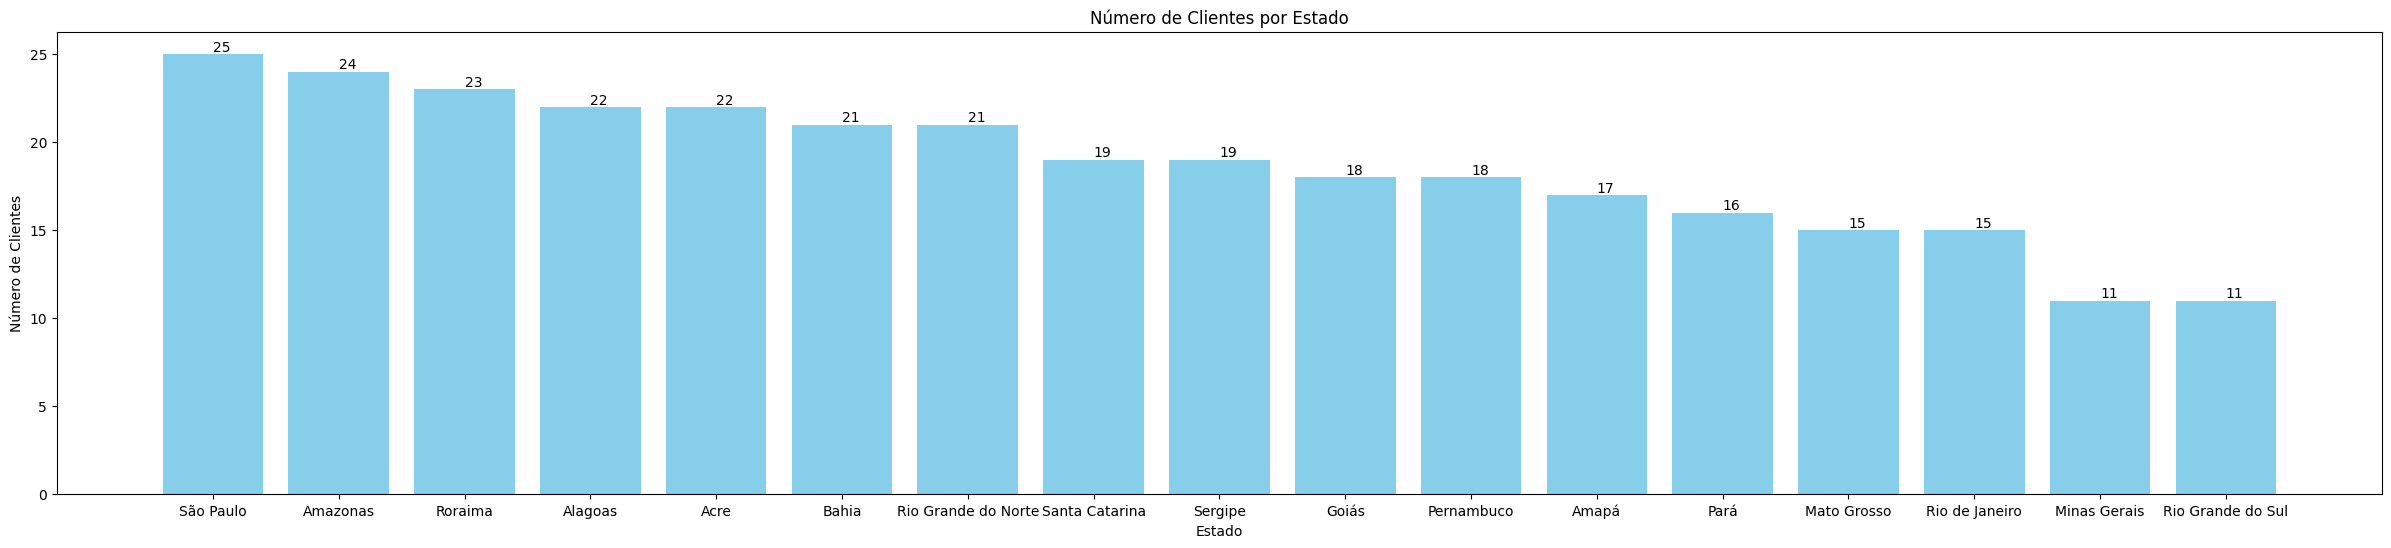

In [56]:
plt.figure(figsize=(30, 6))
bars = plt.bar(clientes_por_estado['estado'], clientes_por_estado['numero_clientes'], color='skyblue')
plt.xlabel('Estado')
plt.ylabel('Número de Clientes')
plt.title('Número de Clientes por Estado')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom')
plt.show()


In [58]:
estado_maior_numero_clientes = clientes_por_estado.loc[clientes_por_estado['numero_clientes'].idxmax()]
estado_menor_numero_clientes = clientes_por_estado.loc[clientes_por_estado['numero_clientes'].idxmin()]

print(f"O estado com maior número de clientes é {estado_maior_numero_clientes['estado']} com {estado_maior_numero_clientes['numero_clientes']} clientes.")

O estado com maior número de clientes é São Paulo com 25 clientes.


Através dessa análise, percebe-se que, nesse cenário, o estado que tem maior oportunidade de crescimento é o estado de MG e RS.

### Valor de Contrato dos clientes por estado

In [66]:
def format_millions(value, pos):
    return f'{value * 1e-6:.2f}M'

In [63]:
valor_total_por_estado = df_clientes_estado.groupby('Estado')['Valor Contrato Anual'].sum().reset_index().sort_values(by='Valor Contrato Anual', ascending=False)
valor_total_por_estado

,Estado,Valor Contrato Anual
1,Alagoas,6759000.0
16,São Paulo,6246000.0
0,Acre,5845500.0
3,Amazonas,5800500.0
10,Rio Grande do Norte,5701500.0
4,Bahia,5013000.0
14,Santa Catarina,4995000.0
5,Goiás,4738500.0
8,Pará,4540500.0
15,Sergipe,4482000.0


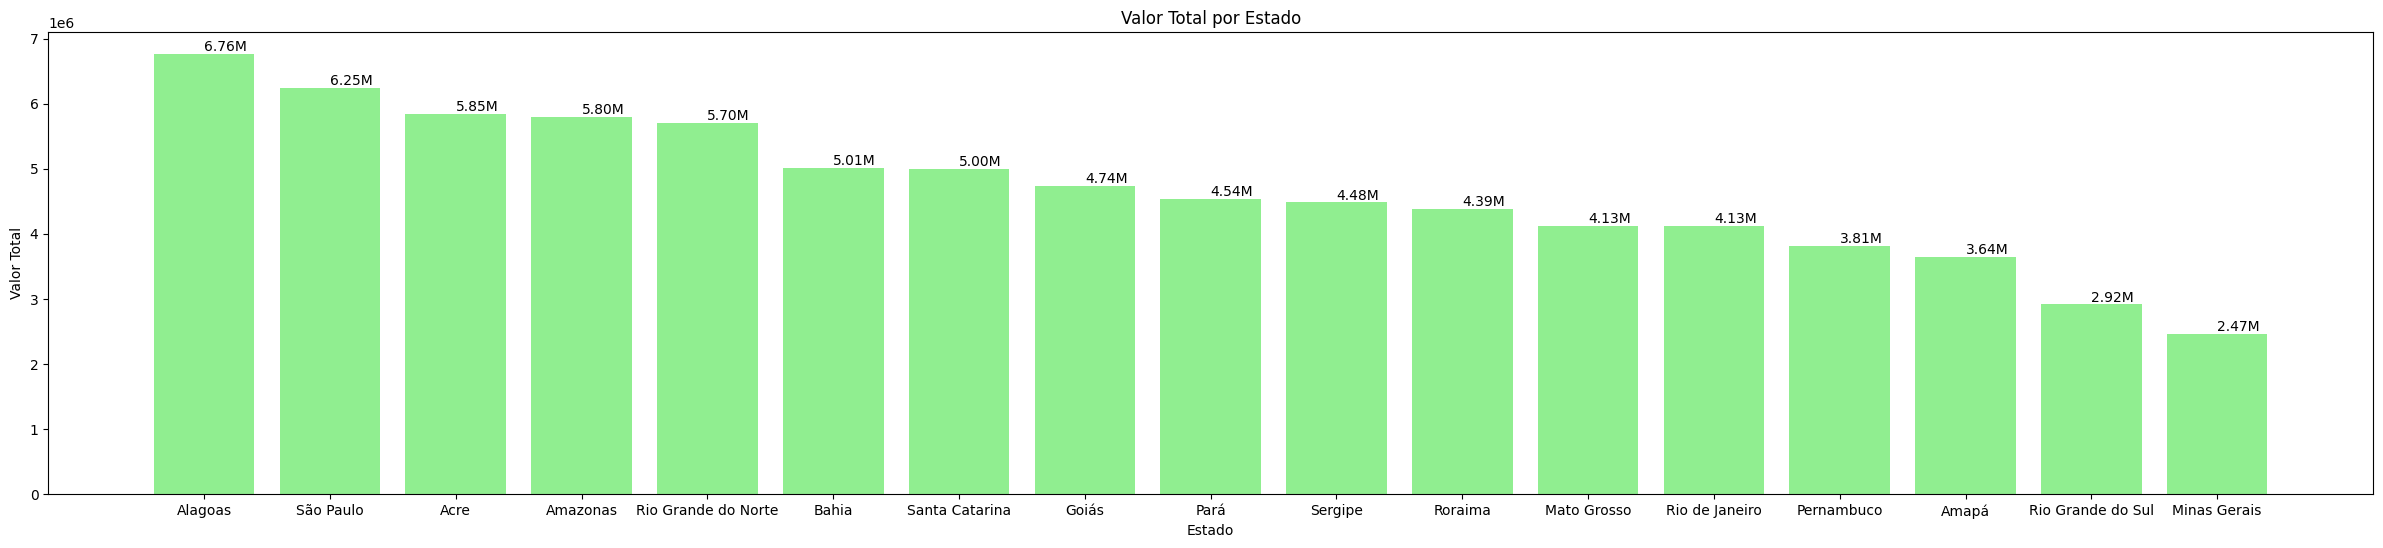

In [69]:
plt.figure(figsize=(30, 6))
bars = plt.bar(valor_total_por_estado['Estado'], valor_total_por_estado['Valor Contrato Anual'], color='lightgreen')
plt.xlabel('Estado')
plt.ylabel('Valor Total')
plt.title('Valor Total por Estado')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, format_millions(yval, 0), va='bottom')

Nota-se que o maior estado em relação a Valor de contrato é Alagoas, que é o 4o maior estado. Enquanto MG permanece como o menor estado também em relação a Valor de Contrato, se mostrando como o estado com maior oportunidade de aumento de clientes e valores de contratos.

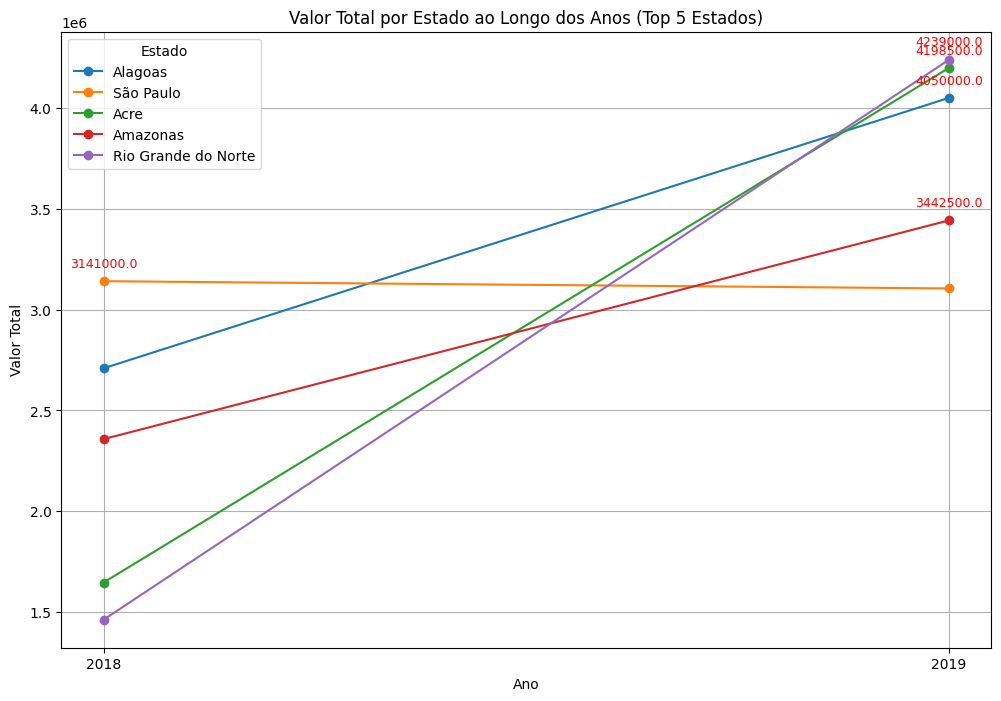

In [84]:
df_clientes_estado['Data Início Contrato'] = pd.to_datetime(df_clientes_estado['Data Início Contrato'], dayfirst=True)

# Extraindo o ano
df_clientes_estado['Ano'] = df_clientes_estado['Data Início Contrato'].dt.year

# Agrupando por estado e ano
valores_por_ano = df_clientes_estado.groupby(['Estado', 'Ano']).agg({
    'Valor Contrato Anual': 'sum'
}).reset_index()


total_por_estado = valores_por_ano.groupby('Estado')['Valor Contrato Anual'].sum().reset_index()
total_por_estado.columns = ['Estado', 'Valor Contrato Anual']


top_5_estados = total_por_estado.nlargest(5, 'Valor Contrato Anual')['Estado']

valores_por_ano_top_5 = valores_por_ano[valores_por_ano['Estado'].isin(top_5_estados)]

# Criando gráficos de linha para comparar ano a ano
fig, ax = plt.subplots(figsize=(12, 8))

# Plotando as linhas
for estado in top_5_estados:
    df_estado = valores_por_ano_top_5[valores_por_ano_top_5['Estado'] == estado]
    ax.plot(df_estado['Ano'], df_estado['Valor Contrato Anual'], marker='o', label=estado)


ax.set_title('Valor Total por Estado ao Longo dos Anos (Top 5 Estados)')
ax.set_xlabel('Ano')
ax.set_ylabel('Valor Total')
ax.legend(title='Estado')

# Destacar os picos
for estado in top_5_estados:
    df_estado = valores_por_ano_top_5[valores_por_ano_top_5['Estado'] == estado]
    picos = df_estado[df_estado['Valor Contrato Anual'] == df_estado['Valor Contrato Anual'].max()]
    for _, pico in picos.iterrows():
        ax.annotate(f"{pico['Valor Contrato Anual']}", (pico['Ano'], pico['Valor Contrato Anual']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red')

# Configurar o formato do eixo x para mostrar apenas os anos
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.grid(True)

Nota-se que, com exceção do estado de São Paulo, houve um crescimento do ano de 2018 a 2019 no valor total de contrato dos clientes.

### Quantidade de funcionários por estado

In [134]:
df_funcionarios_estado = pd.merge(df_funcionarios, df_cep, on='CEP', how='left')
df_funcionarios_cargos = pd.merge(df_funcionarios_estado, df_cargos, on='Cargo', how='left')
df_funcionarios_final = pd.merge(df_funcionarios_cargos, df_pq, left_on='COD Nível', right_on='sigla nivel', how='left')
df_funcionarios_final.head()

,ID RH,RG,CPF,Ramal,Estado Civil,Nome Completo,Login,Data de Nascimento,CEP,Data de Contratacao,...,COD Área,COD Nível,Quadro,Bonus,Contratacao,id,ID da area_y,id nivel,cargo,sigla nivel
0,1,6ff98c75beccb9fc4fd78f9091bb0bfa,8ac82dda503501ab844834b79f4ccde9,6482,C,d4b2a0b289df221adc8f83c2237e30b9,eaaea66956aadf6d20945ec29d83e913,25569,20125535,38792,...,JAJ,JE,Efetivo,S,Diretoria,5.0,10.0,V,Diretor,JE
1,2,1c7e129f3d5f23907d79b22f5a1a1a62,cc52d005b6d6b0b3db1fd565ce83e826,6177,C,9e6ab30002bbfc6c708e7256b2b9bc37,6534970d81898fbd1380af4fd13ef58e,27145,25995770,39605,...,EDE,JA,Efetivo,N,Gerente,1.0,0.0,I,Estagiário,JA
2,3,02f3ad953e2460d46736ac847d115118,baaec95edf3126994550bbd6169a5c83,7736,C,3d0f56774b9dd51e1454bfd446b9f159,5071afa8131030ec6bc9e4842d540838,32880,37278465,39450,...,BAC,JA,Efetivo,N,Gerente,1.0,0.0,I,Estagiário,JA
3,4,688284b981297c0020be0c9b763b973f,f2bbe877ffd19bf2814ec8227eae34f3,5238,C,e2fc87e2217f52a48eb35549408d496a,a0a67d63c365dbd23fe0c5b271ddf53b,34096,49897703,40666,...,BAC,DB,Terceiro,N,RH,2.0,4.0,II,Analista,DB
4,5,e8bf3e74057c0e4f1baac356348ca438,75c597a9e178d69dcd135fbb9ba47525,5182,C,f3a919bb78f6ca29599130d693458125,cbfc15f99f9f8bf71c9efa9bb6e408d4,27118,30149335,36601,...,BAC,DB,Terceiro,N,RH,2.0,4.0,II,Analista,DB


In [135]:
# Selecionar as colunas desejadas
df_funcionarios_final = df_funcionarios_final[
    ['Nome Completo', 'Login', 'CEP', 'cargo', 'Estado', 'Região']
]


In [136]:
df_funcionarios_final

,Nome Completo,Login,CEP,cargo,Estado,Região
0,d4b2a0b289df221adc8f83c2237e30b9,eaaea66956aadf6d20945ec29d83e913,20125535,Diretor,Mato Grosso,Centro - Oeste
1,9e6ab30002bbfc6c708e7256b2b9bc37,6534970d81898fbd1380af4fd13ef58e,25995770,Estagiário,Rio Grande do Norte,Nordeste
2,3d0f56774b9dd51e1454bfd446b9f159,5071afa8131030ec6bc9e4842d540838,37278465,Estagiário,Sergipe,Nordeste
3,e2fc87e2217f52a48eb35549408d496a,a0a67d63c365dbd23fe0c5b271ddf53b,49897703,Analista,Mato Grosso,Centro - Oeste
4,f3a919bb78f6ca29599130d693458125,cbfc15f99f9f8bf71c9efa9bb6e408d4,30149335,Analista,Mato Grosso,Centro - Oeste
...,...,...,...,...,...,...
534,1ed748bc49a16edca44f1053ba3f1444,87520942d35d40ac4be127557bd92f7a,45499870,Diretor,Sergipe,Nordeste
535,27f6c749fe9f144c0034b41bc0aa719c,99fe46b42622011d567ad0659dfe438a,21517794,Analista,Amazonas,Norte
536,2b2748e5edd44f668da97ecf25f2d06a,4a534315285ba715642d21a9bad05129,34689811,Analista,Goiás,Centro - Oeste
537,e054d6f8d00f4b823342ffb2998c834c,9a4471a5794d010f192122711c30aff6,31097240,NaN,Roraima,Norte


<ipython-input-128-3ec9beb61a20>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Estado', y='Quantidade de Funcionários', data=funcionarios_por_estado, palette='viridis')


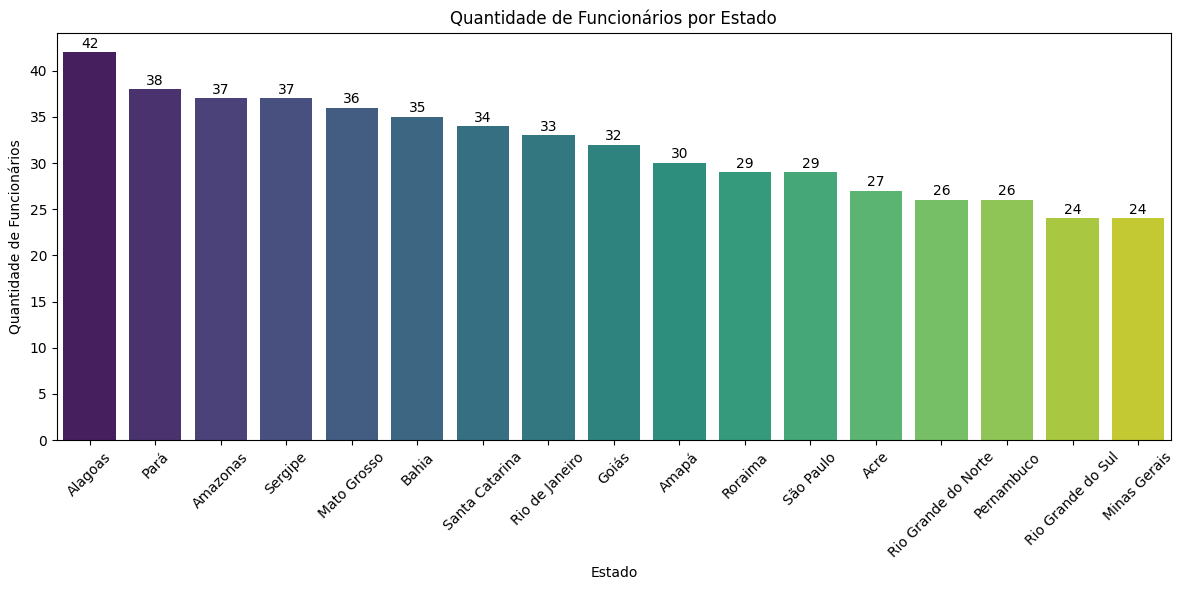

In [128]:
funcionarios_por_estado = df_funcionarios_final.groupby('Estado')['Nome Completo'].count().reset_index()
funcionarios_por_estado.columns = ['Estado', 'Quantidade de Funcionários']
funcionarios_por_estado = funcionarios_por_estado.sort_values(by='Quantidade de Funcionários', ascending=False)

# Criar o gráfico para a quantidade de funcionários por estado
plt.figure(figsize=(12, 6))
sns.barplot(x='Estado', y='Quantidade de Funcionários', data=funcionarios_por_estado, palette='viridis')

plt.title('Quantidade de Funcionários por Estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Funcionários')
plt.xticks(rotation=45)

# rótulos no topo das barras
for index, row in funcionarios_por_estado.iterrows():
    plt.text(row['Estado'], row['Quantidade de Funcionários'] + 0.5, row['Quantidade de Funcionários'], ha='center')

plt.tight_layout()

O estado com a maior quantidade de funcionários é Alagoas.

### Quantidade de funcionários por cargo em cada estado

<Figure size 1400x800 with 0 Axes>

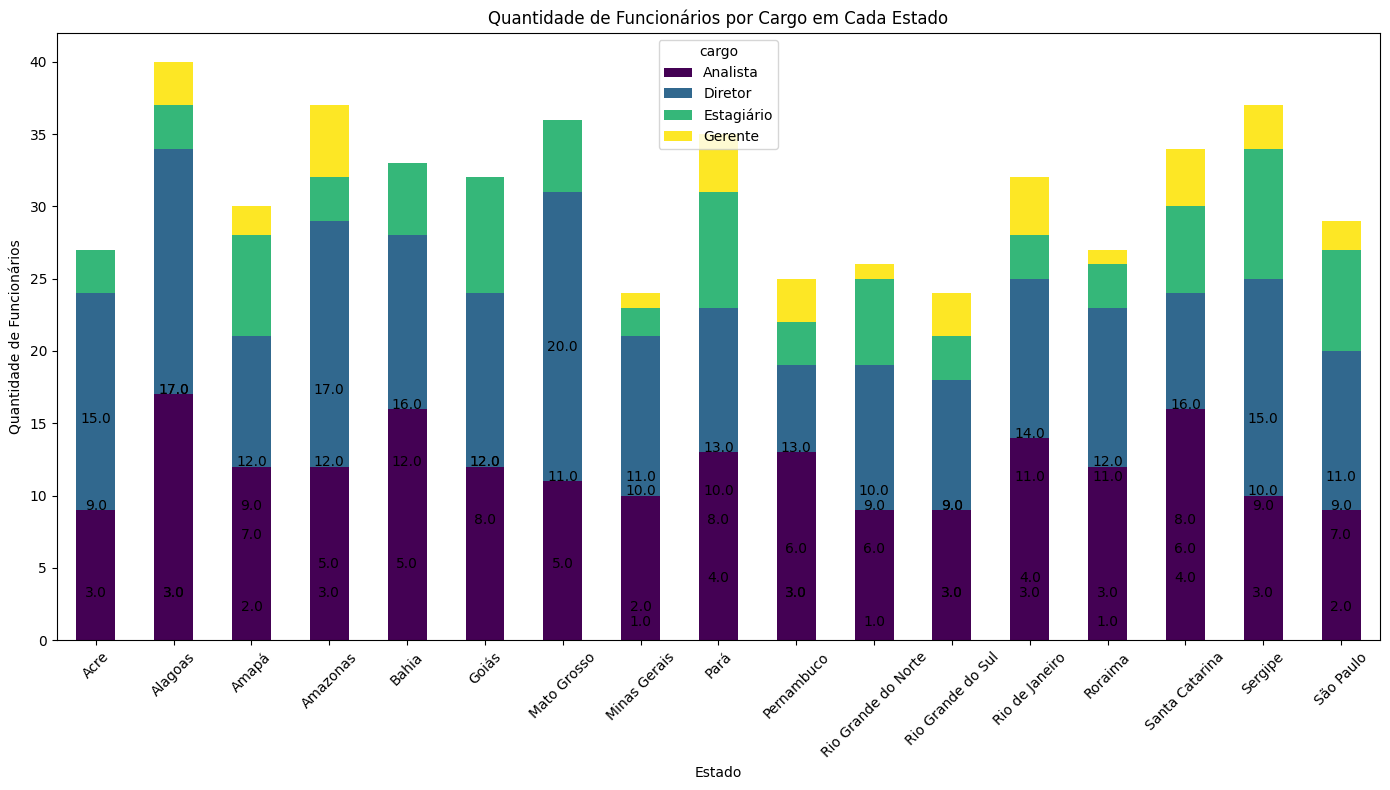

In [130]:
cargos_por_estado = pd.crosstab(df_funcionarios_final['Estado'], df_funcionarios_final['cargo'])

# Converter as colunas de estados para categoria para configurar o grafico
cargos_por_estado.index = cargos_por_estado.index.astype('category')
cargos_por_estado.columns = cargos_por_estado.columns.astype('category')

# gráfico de barras empilhadas
plt.figure(figsize=(14, 8))
ax = cargos_por_estado.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

plt.title('Quantidade de Funcionários por Cargo em Cada Estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Funcionários')
plt.xticks(rotation=45)

# rótulos
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()

### Estados com maior quantidade de funcionários em posição de diretor

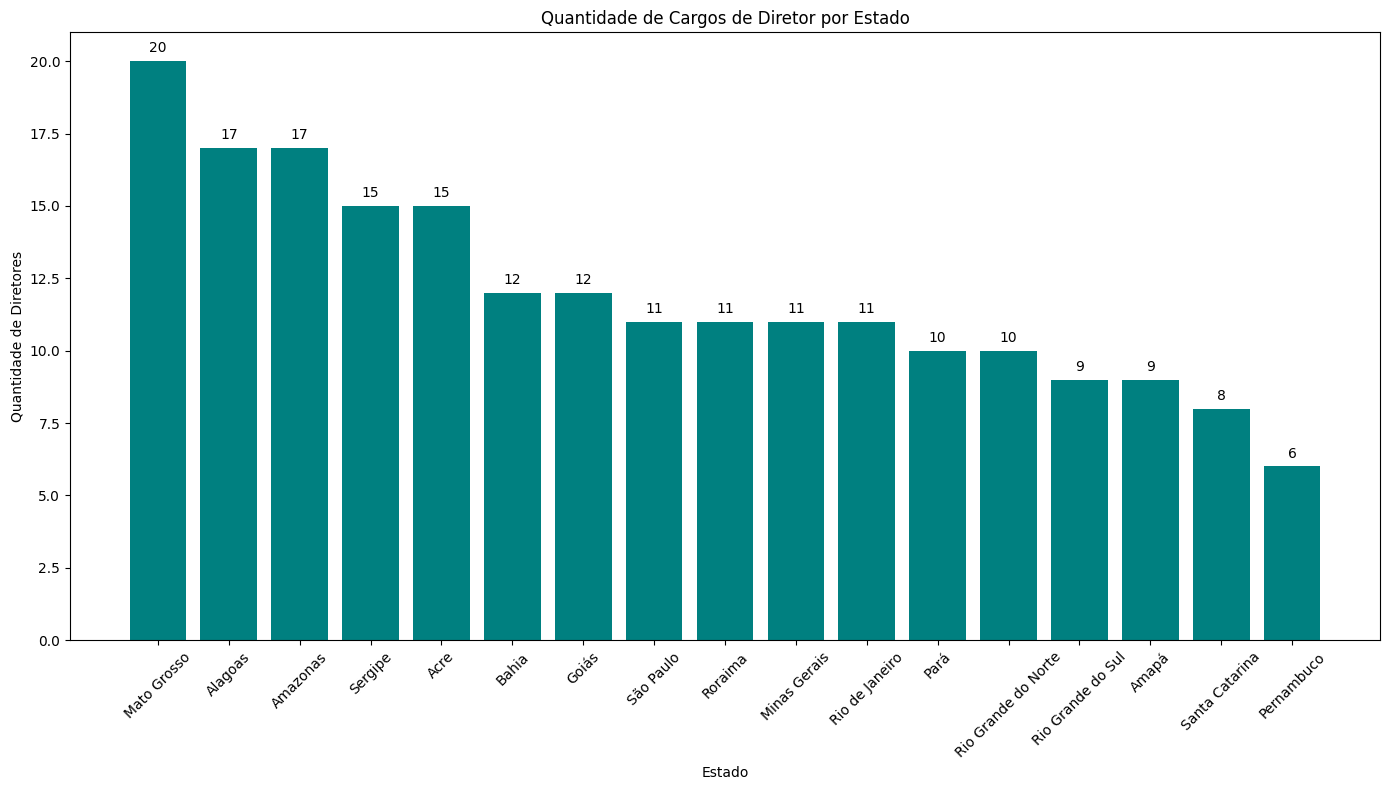

In [131]:
df_diretores = df_funcionarios_final[df_funcionarios_final['cargo'] == 'Diretor']

diretores_por_estado = df_diretores['Estado'].value_counts().reset_index()
diretores_por_estado.columns = ['Estado', 'Quantidade de Diretores']

plt.figure(figsize=(14, 8))
plt.bar(diretores_por_estado['Estado'], diretores_por_estado['Quantidade de Diretores'], color='teal')
plt.title('Quantidade de Cargos de Diretor por Estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Diretores')
plt.xticks(rotation=45)

for i, value in enumerate(diretores_por_estado['Quantidade de Diretores']):
    plt.text(i, value + 0.2, str(value), ha='center', va='bottom')

plt.tight_layout()

O estado com a maior direção da empresa é o Mato Grosso.